## Value-at-Risk: Forecast Evaluation

**Functions**

`sm.OLS`, `stats.bernoulli`

### Exercise 83
    
Compare the 95% FHS VaR to the 95% HS VaR.

In [1]:
import pandas as pd

# Load Data
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

with pd.HDFStore("./data/hs-var.h5", mode="r") as hdf:
    sp500_hs = hdf.get("sp500_var")
    eurusd_hs = hdf.get("eurusd_var")
with pd.HDFStore("./data/fhs-var.h5", mode="r") as hdf:
    sp500_fhs = hdf.get("sp500_var")
    eurusd_fhs = hdf.get("eurusd_var")

# Rename columns to distinguish
sp500_hs.columns = [c.replace("VaR", "HS VaR") for c in sp500_hs.columns]
eurusd_hs.columns = [c.replace("VaR", "HS VaR") for c in eurusd_hs.columns]

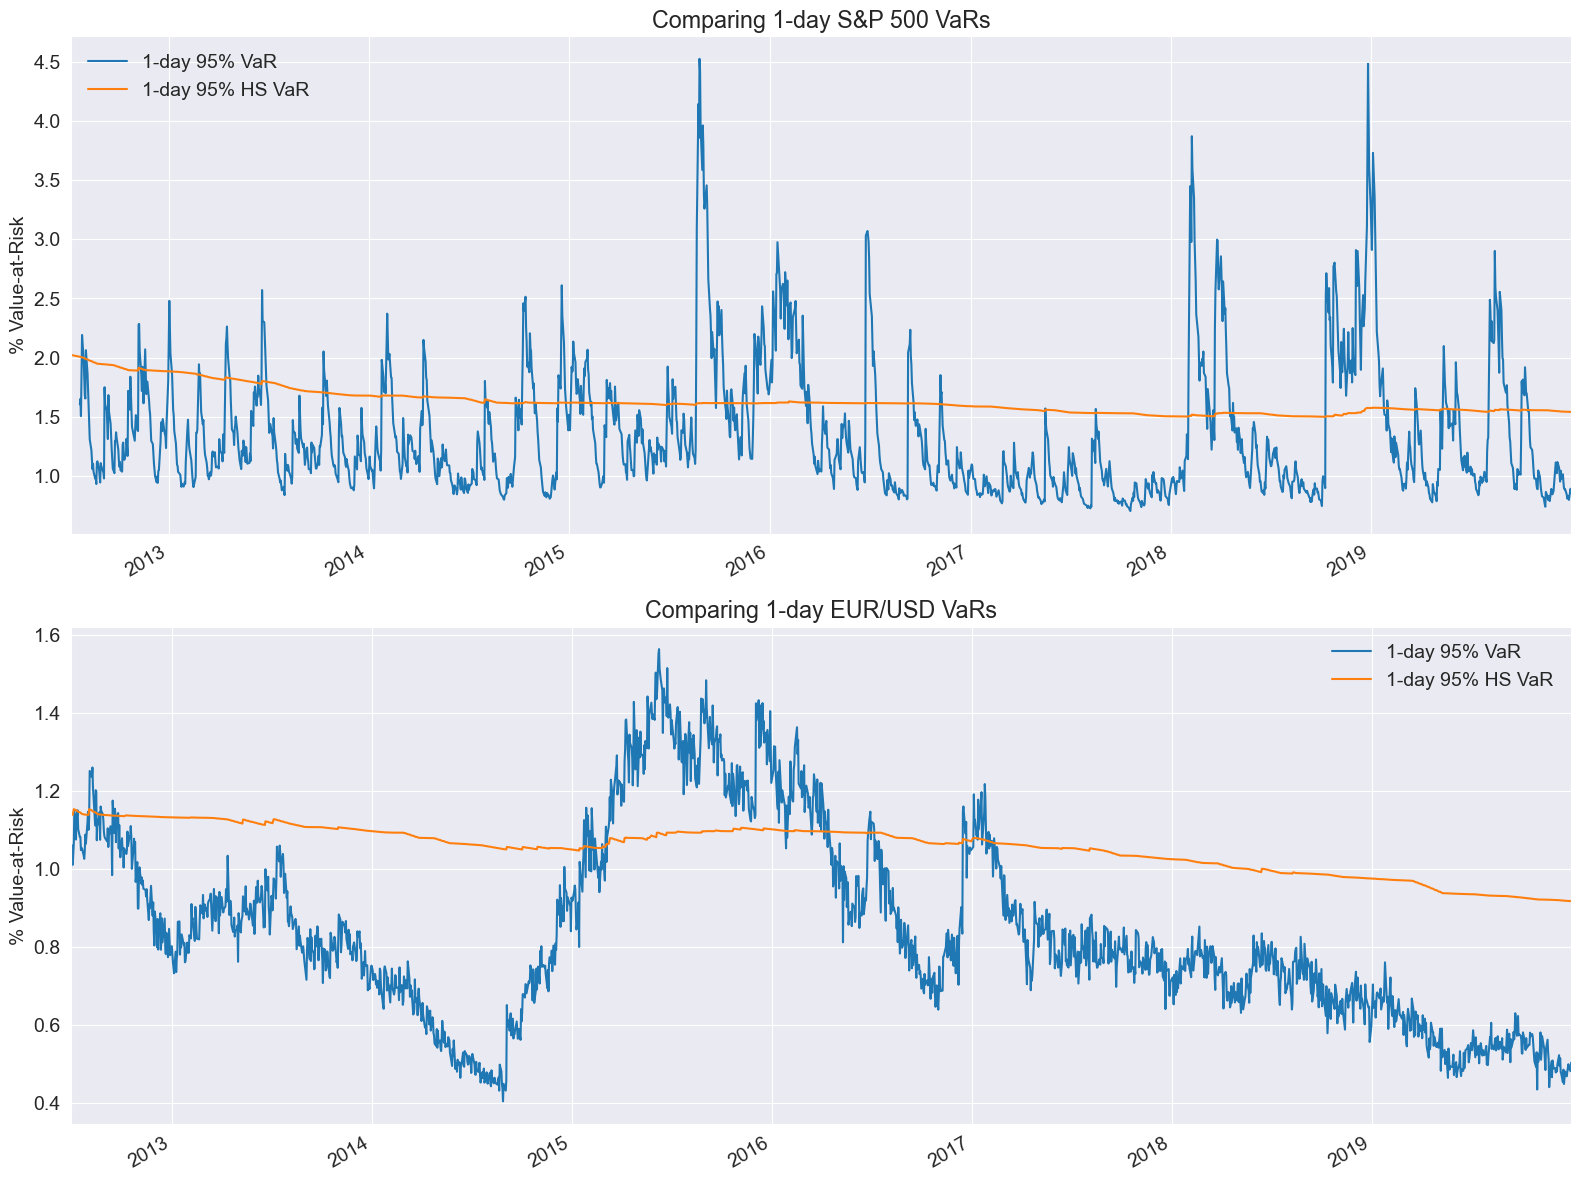

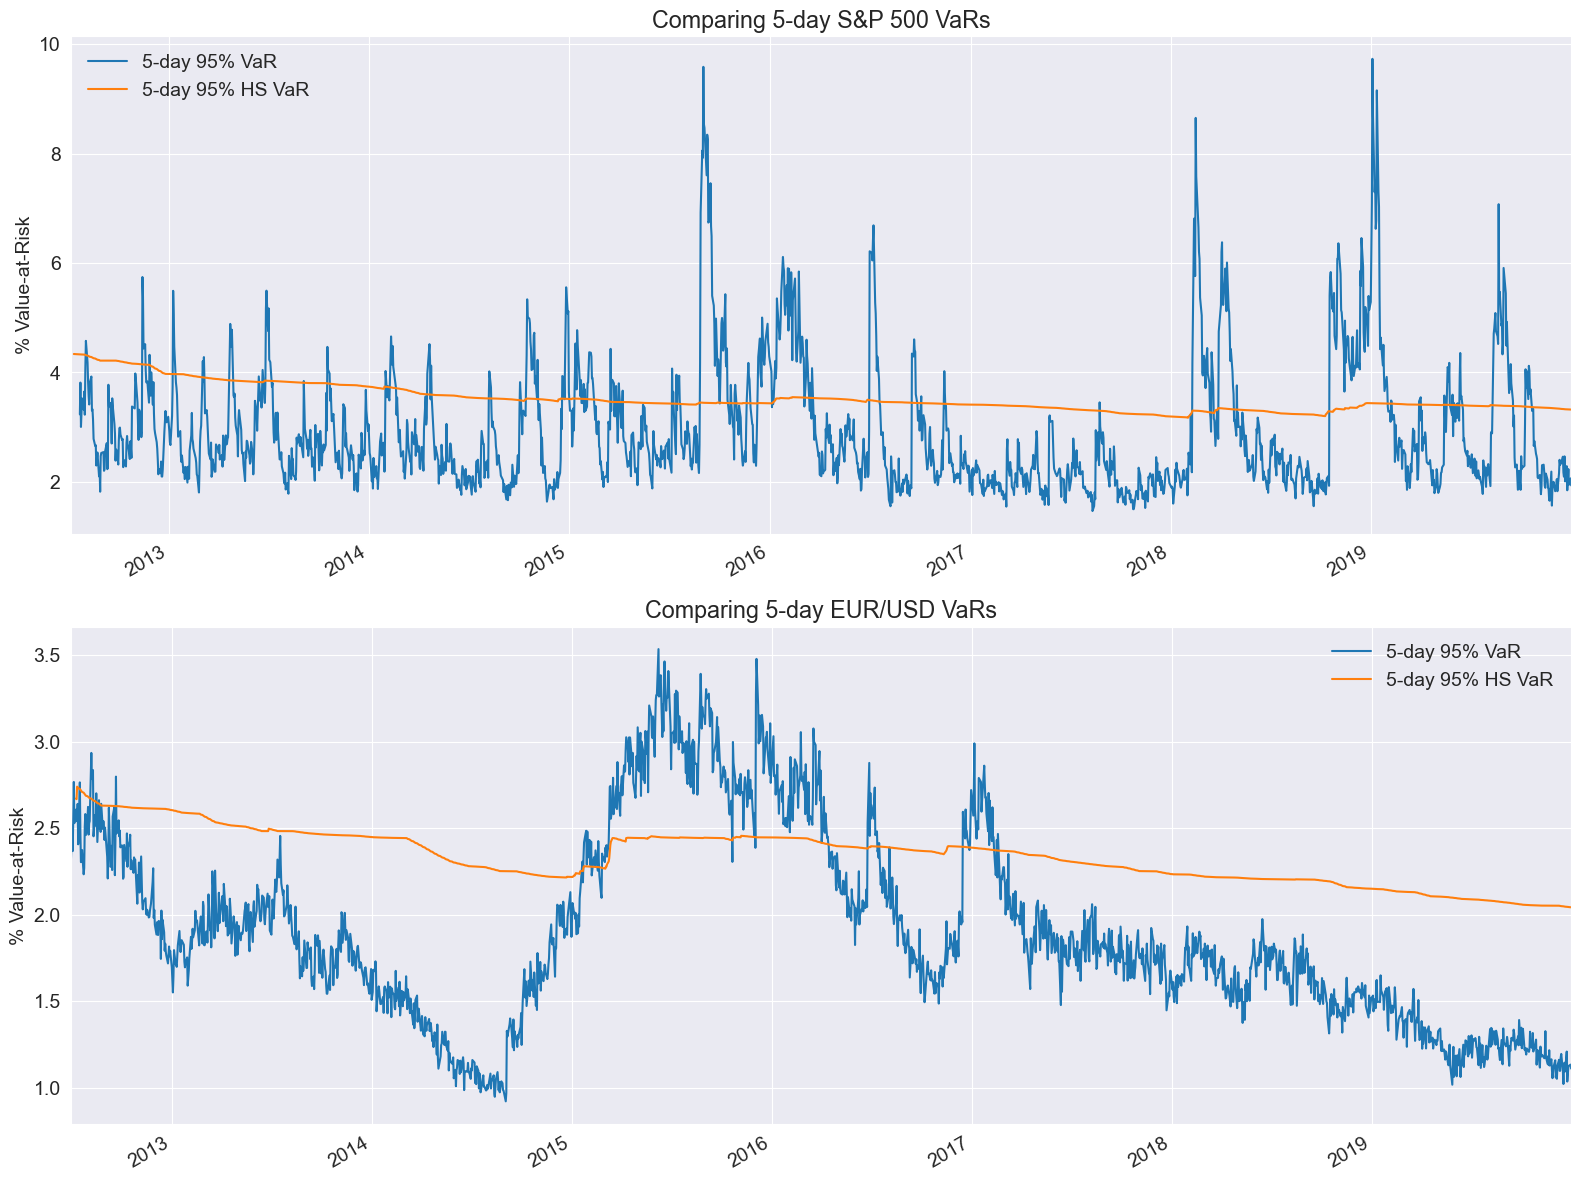

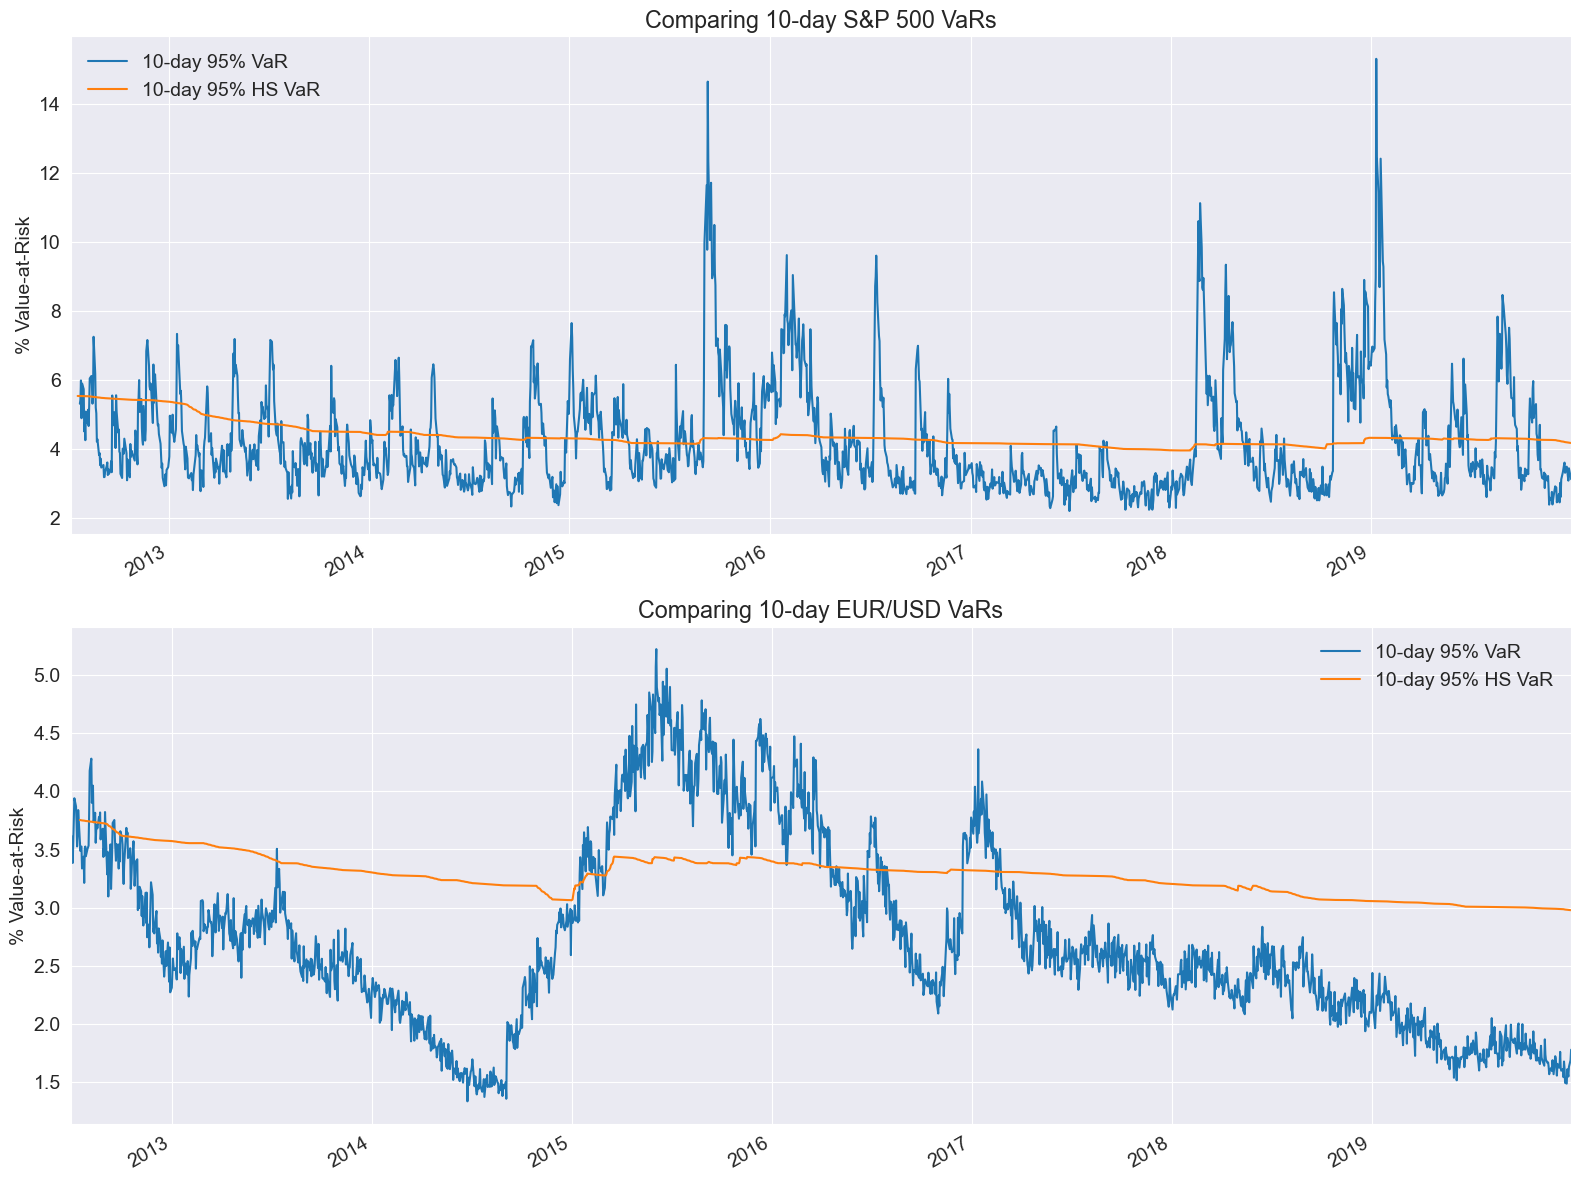

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=14)

sp500_var = pd.concat([sp500_hs, sp500_fhs], axis=1)
eurusd_var = pd.concat([eurusd_hs, eurusd_fhs], axis=1)

for h in (1, 5, 10):
    fig, axes = plt.subplots(2, 1)
    cols = [f"{h}-day 95% VaR", f"{h}-day 95% HS VaR"]
    ax = sp500_var[cols].plot(ax=axes[0], legend=False)
    ax.set_title(f"Comparing {h}-day S&P 500 VaRs")
    ax.set_xlabel(None)
    ax.set_ylabel("% Value-at-Risk")
    ax.legend(frameon=False)
    ax.set_xlim(sp500_var.index.min(), sp500_var.index.max())

    ax = eurusd_var[cols].plot(ax=axes[1], legend=False)
    ax.set_title(f"Comparing {h}-day EUR/USD VaRs")
    ax.set_xlabel(None)
    ax.set_ylabel("% Value-at-Risk")
    ax.set_xlim(eurusd_var.index.min(), eurusd_var.index.max())
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)

#### Explanation

The HS VaRs are very smooth while the FHS VaRs are more dynamic.  The FHS VaRs are mostly driven by changes in volatility. The dynamics in the EUR/USD data are substantially different with long-swings evident in volatility.

### Exercise 84
Evaluate the FHS and HS VaR forecasts constructed in the previous exercises using:

* HIT tests
* The Bernoulli test for unconditionally correct VaR
* Christoffersen’s test for conditionally correct VaR


hit_fhs    0.013881
hit_hs     0.033636
dtype: float64
          hit_fhs    hit_hs
hit_fhs  1.000000  0.585327
hit_hs   0.585327  1.000000


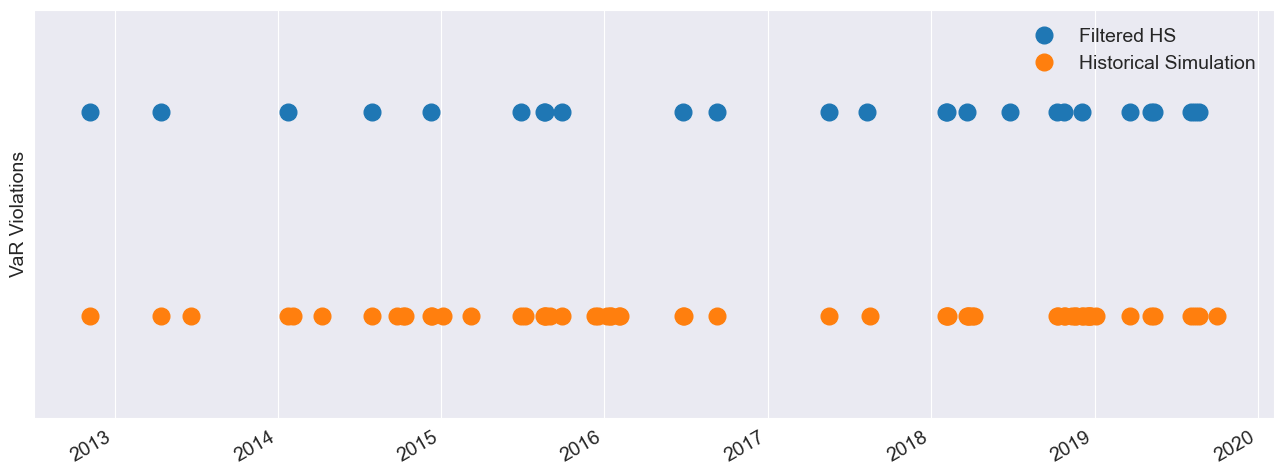

In [3]:
# Construct HITS
cols = ["1-day 95% VaR", f"1-day 95% HS VaR"]
combined = pd.concat([sp500_returns, sp500_var[cols]], axis=1).dropna()
combined.columns = ["ret", "fhs", "hs"]
hit_fhs = combined.ret < -combined.fhs
hit_hs = combined.ret < -combined.hs
hits = pd.DataFrame({"hit_fhs": hit_fhs, "hit_hs": hit_hs}).astype("float")
print(hits.mean())
print(hits.corr())
import numpy as np

temp = hits.replace(0.0, np.nan)
temp.iloc[:, 0] += 0.05
temp.iloc[:, 1] -= 0.05
temp.columns = ["Filtered HS", "Historical Simulation"]
plt.rc("figure", figsize=(16, 6))
ax = temp.plot(marker="o", linestyle="none", legend=False, markersize=12)
ax.set_ylim(0.9, 1.10)
ax.set_yticks([])
ax.set_ylabel("VaR Violations")
ax.set_xlabel(None)
ax.legend(frameon=False)

#### Explanation


We start by constructing the HITs.  These are computed by comparing -1 times the VaRs to the returns. We previously aligned the VaRs so we don't need to shift them here. 

We see that both produce fewer HITs than they should, and that the FHS is particularly bad. The are mildly correlated with about half of the HITs being observed in the same period.The HS violation appear to be clustered in 2016 and 2019. 

In [4]:
from scipy import stats

phat = hits.mean(0)
for col in hits:
    hit = hits[col]
    phat = hit.mean()
    llf = stats.bernoulli(phat).logpmf(hit).sum()
    llf0 = stats.bernoulli(0.05).logpmf(hit).sum()
    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(1).cdf(lr)
    print(f"Method: {col} LR: {lr} P-value: {pval}")

Method: hit_fhs LR: 71.2036991699731 P-value: 0.0
Method: hit_hs LR: 11.874810141248076 P-value: 0.0005689826984602853


#### Explanation
This is the simplest test and only requires evaluating the Bernoulli log-likelihood at the MLE ($\overline{HIT}$, the average) and at the value under the null (5%).  The test statistic is 2 times the difference in the two and has a $\chi^2_1$ distribution.  Both models reject correct specification.

In [5]:
for col in hits:
    hit = hits[col]
    hit_t = hit.shift(1)
    hit_tp1 = hit
    n00 = ((1 - hit_t) * (1 - hit_tp1)).sum()
    n10 = (hit_t * (1 - hit_tp1)).sum()
    n01 = ((1 - hit_t) * hit_tp1).sum()
    n11 = (hit_t * hit_tp1).sum()

    p00_hat = n00 / (n00 + n01)
    p11_hat = n11 / (n11 + n10)
    p00 = p00_hat
    p11 = p11_hat
    llf = (
        n00 * np.log(p00)
        + n10 * np.log(1 - p00)
        + n11 * np.log(p11)
        + n10 * np.log(1 - p11)
    )

    p11 = 0.05
    p00 = 1 - p11
    llf0 = (
        n00 * np.log(p00)
        + n10 * np.log(1 - p00)
        + n11 * np.log(p11)
        + n10 * np.log(1 - p11)
    )

    lr = 2 * (llf - llf0)
    pval = 1 - stats.chi2(2).cdf(lr)
    print(f"Christoffersen's test, Method: {col} LR: {lr} P-value: {pval}")

Christoffersen's test, Method: hit_fhs LR: 74.91377672605034 P-value: 0.0
Christoffersen's test, Method: hit_hs LR: 29.272074382438063 P-value: 4.401997696357185e-07


#### Explanation
Christoffersen's test is also fairly simple.  We first construct the vectors of HITs at time t and t+1 to use the formula in the noted.  We then compute $n_{ij}$ for $i,j\in\{0,1\}$. These are then used to estimate the model parameters which allow the log-likelihood to be computed for both the MLE and the null.  Two times this difference is the test statistic which has a $\chi^2_2$ distribution.

In [6]:
import statsmodels.api as sm

results = {}
for col in hits:
    hit = hits[col] - 0.05
    lags = [hit.shift(i + 1) for i in range(5)]
    lags = pd.concat(lags, axis=1)
    var_col = "fhs" if "fhs" in col else "hs"
    var = combined[var_col]
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]
    x = sm.add_constant(data.iloc[:, 1:])
    x.columns = ["const", "var"] + [f"hit_L_{i}" for i in range(1, 6)]
    res = sm.OLS(y, x).fit()
    r = np.eye(7)
    joint = res.wald_test(r, scalar=True)
    stat = joint.statistic
    results[col] = {"summary": res.summary()}
    results[col]["stat"] = f"Stat: {stat}, P-value: {joint.pvalue}"

In [7]:
results["hit_fhs"]["summary"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                hit_fhs   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     14.32
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           5.18e-16
Time:                        15:14:51   Log-Likelihood:                 1397.1
No. Observations:                1868   AIC:                            -2780.
Df Residuals:                    1861   BIC:                            -2741.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1046      0.009    -12.029      0.000      -0.122      -0.088
var            0.0465      0.005      8.662      0.000       0.036       0.057
hit_L_1        0.0243      0.023      1.047      0.295      -0.021       0.070
hit_L_2       -0.0578      0.023     -2.486      0.013      -0.103      -0.012
hit_L_3       -0.0520      0.023     -2.243      0.025      -0.097      -0.007
hit_L_4       -0.0109      0.023     -0.472      0.637      -0.056       0.035
hit_L_5       -0.0537      0.023     -2.327      0.020      -0.099      -0.008
==============================================================================
Omnibus:                     2507.912   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           310612.957
Skew:                           7.749   Prob(JB):                         0.00
Kurtosis:                      64.242   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
print(results["hit_fhs"]["stat"])

Stat: 38.65161421816153, P-value: 6.529473223296163e-51


In [9]:
results["hit_hs"]["summary"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hit_hs   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     9.632
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.85e-10
Time:                        15:14:51   Log-Likelihood:                 575.81
No. Observations:                1868   AIC:                            -1138.
Df Residuals:                    1861   BIC:                            -1099.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1074      0.062      1.733      0.083      -0.014       0.229
var           -0.0732      0.038     -1.923      0.055      -0.148       0.001
hit_L_1        0.1113      0.023      4.805      0.000       0.066       0.157
hit_L_2        0.0715      0.023      3.070      0.002       0.026       0.117
hit_L_3        0.0151      0.023      0.645      0.519      -0.031       0.061
hit_L_4        0.0413      0.023      1.774      0.076      -0.004       0.087
hit_L_5        0.0438      0.023      1.892      0.059      -0.002       0.089
==============================================================================
Omnibus:                     1823.404   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50937.905
Skew:                           4.955   Prob(JB):                         0.00
Kurtosis:                      26.585   Cond. No.                         33.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
print(results["hit_hs"]["stat"])

Stat: 10.483905074344078, P-value: 5.623611738027114e-13


#### Explanation
Finally we can run the dynamic quantile test (or HIT regression). The model estimated is

$$ HIT_{t+1} = \gamma_0 + \gamma_1 VaR_{t+1|t} + \sum_{i=1}^5 \gamma_{1+i} HIT_{t-i+1} + \epsilon_t+1 $$

We construct the lags using `shift`.  Both models are rejected.  The HS model appears to have substantial 
serial correlation while the FHS as serial correlation, the wrong level, and excess sensitivity to the 
forecast VaR.
    

Mean HIT %
hit_fhs    0.040043
hit_hs     0.035238
dtype: float64
Correlation across HITs
          hit_fhs    hit_hs
hit_fhs  1.000000  0.743743
hit_hs   0.743743  1.000000


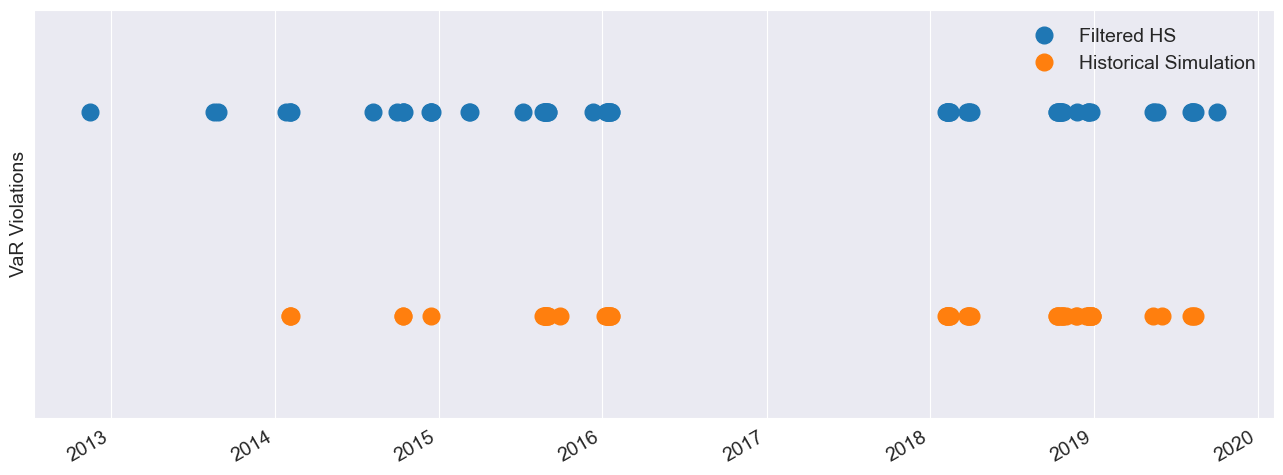

In [11]:
# Construct HITS
cols = ["10-day 95% VaR", f"10-day 95% HS VaR"]
rets_10 = 100 * sp500.SP500.pct_change(10)
combined = pd.concat([rets_10, sp500_var[cols]], axis=1).dropna()
combined.columns = ["ret", "fhs", "hs"]
hit_fhs = combined.ret < -combined.fhs
hit_hs = combined.ret < -combined.hs
hits = pd.DataFrame({"hit_fhs": hit_fhs, "hit_hs": hit_hs}).astype("float")
print("Mean HIT %")
print(hits.mean())
print("Correlation across HITs")
print(hits.corr())
import numpy as np

temp = hits.replace(0.0, np.nan)
temp.iloc[:, 0] += 0.05
temp.iloc[:, 1] -= 0.05
temp.columns = ["Filtered HS", "Historical Simulation"]
ax = temp.plot(marker="o", linestyle="none", legend=False, markersize=12)
ax.set_ylim(0.9, 1.10)
ax.set_yticks([])
ax.set_ylabel("VaR Violations")
ax.set_xlabel(None)
ax.legend(frameon=False)

#### Explanation

We construct the 10-day HITs using the VaR forecasts and the 10-day returns
computed using `pct_change(10)`. The forecasts are already aligned and
so the HITs are just violations. The plot shows that both models seem to have 
important problems.  The FHS model has a 2-year period with no HITs.  The HS
forecast has 2 distinct period with no HITs. 

Both models produce close to the correct number of HITs and the HITs are
fairly correlated across the two models. 


In [12]:
horizon = 10
for col in hits:
    hit = hits[col] - 0.05
    lags = [hit.shift(i + horizon) for i in range(5)]
    lags = pd.concat(lags, axis=1)
    var_col = "fhs" if "fhs" in col else "hs"
    var = combined[var_col]
    data = pd.concat([hit, var, lags], axis=1).dropna()
    y = data.iloc[:, 0]
    x = sm.add_constant(data.iloc[:, 1:])
    x.columns = ["const", "var"] + [f"hit_L_{horizon+i}" for i in range(1, 6)]
    bw = int(1.2 * y.shape[0] ** (2 / 5))
    res = sm.OLS(y, x).fit(cov_type="HAC", cov_kwds={"maxlags": bw})
    r = np.eye(7)
    joint = res.wald_test(r, scalar=True)
    stat = joint.statistic

    joint_ex = res.wald_test(r[1:, :], scalar=True)
    stat_ex = joint_ex.statistic

    results[col] = {"summary": res.summary()}
    results[col]["stat"] = f"Stat: {stat}, P-value: {joint.pvalue}"
    results[col][
        "stat ex"
    ] = f"Stat ex. constant: {stat_ex}, P-value ex. constant: {joint_ex.pvalue}"

In [13]:
results["hit_fhs"]["summary"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                hit_fhs   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.963
Date:                Wed, 27 Aug 2025   Prob (F-statistic):            0.00699
Time:                        15:14:51   Log-Likelihood:                 387.82
No. Observations:                1859   AIC:                            -761.6
Df Residuals:                    1852   BIC:                            -722.9
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.030      0.151      0.880      -0.053       0.062
var           -0.0035      0.006     -0.556      0.578      -0.016       0.009
hit_L_11      -0.0245      0.015     -1.674      0.094      -0.053       0.004
hit_L_12       0.0186      0.026      0.713      0.476      -0.032       0.070
hit_L_13      -0.0136      0.008     -1.633      0.103      -0.030       0.003
hit_L_14      -0.0108      0.009     -1.187      0.235      -0.029       0.007
hit_L_15      -0.0181      0.009     -1.910      0.056      -0.037       0.000
==============================================================================
Omnibus:                     1713.888   Durbin-Watson:                   0.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36647.899
Skew:                           4.646   Prob(JB):                         0.00
Kurtosis:                      22.667   Cond. No.                         37.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

In [14]:
print(results["hit_fhs"]["stat"])

Stat: 354.8742144463632, P-value: 1.1148226825271726e-72


In [15]:
print(results["hit_fhs"]["stat ex"])

Stat ex. constant: 17.7805139407112, P-value ex. constant: 0.006804761815481449


In [16]:
results["hit_hs"]["summary"]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 hit_hs   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.465
Date:                Wed, 27 Aug 2025   Prob (F-statistic):              0.186
Time:                        15:14:51   Log-Likelihood:                 505.41
No. Observations:                1859   AIC:                            -996.8
Df Residuals:                    1852   BIC:                            -958.1
Df Model:                           6                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1760      0.082      2.146      0.032       0.015       0.337
var           -0.0437      0.017     -2.596      0.009      -0.077      -0.011
hit_L_11      -0.0122      0.016     -0.738      0.460      -0.045       0.020
hit_L_12      -0.0129      0.013     -0.982      0.326      -0.039       0.013
hit_L_13      -0.0220      0.015     -1.495      0.135      -0.051       0.007
hit_L_14       0.0167      0.042      0.401      0.688      -0.065       0.098
hit_L_15       0.0020      0.032      0.064      0.949      -0.060       0.064
==============================================================================
Omnibus:                     1810.277   Durbin-Watson:                   0.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47998.087
Skew:                           4.963   Prob(JB):                         0.00
Kurtosis:                      25.829   Cond. No.                         59.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 24 lags and without small sample correction
"""

In [17]:
print(results["hit_hs"]["stat"])

Stat: 54.730100360262554, P-value: 1.686222750679253e-09


In [18]:
print(results["hit_hs"]["stat ex"])

Stat ex. constant: 8.788942045537258, P-value ex. constant: 0.1858003665805345


#### Explanation

First note that the lagged hits start at 10 lags. This is necessary 
since everything on the right-hand side of the model must be known
at time $t$, and lags 1,...,9 only happen in the future. 

The tests use `wald_test` and restrict all coefficient to be zero so
that the loading matrix in $R\hat{\beta}$ is $I_k$ where $k$ is the number
of variables in the model. I also included a test that ignores the intercept
which uses the same $R$ excluding the first column. 

The regressions use Newey-West (Bartlett) covariance estimators since 
the data used to produce the HITs is overlapping.  

Both models are rejected in the complete test.  The FHS model appears to
have slightly less serial correlation althogh both test specifications 
reject the null that the VaR is correct. 